In [1]:
# pip install, sometimes pims and trackpy behaves weridly with conda
!pip install pims
!pip install https://github.com/soft-matter/trackpy/archive/master.zip


  Using cached https://github.com/soft-matter/trackpy/archive/master.zip
  Preparing metadata (setup.py) ... done
  Using cached looseversion-1.0.3-py3-none-any.whl (6.1 kB)
  Created wheel for trackpy: filename=trackpy-0+unknown-py3-none-any.whl size=129720 sha256=3d496dbc14a87b58872cc1c6cd2f3466e15300c53b82e124e8e51958c0ac90e1
  Stored in directory: /private/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/pip-ephem-wheel-cache-nzbywuex/wheels/ad/f4/55/fa05b5f4b1e83ae408085708919d83c030a6fdfdf63917a08f
Successfully built trackpy
  Attempting uninstall: trackpy
    Found existing installation: trackpy 0.5.0
    Uninstalling trackpy-0.5.0:
      Successfully uninstalled trackpy-0.5.0


In [79]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import glob

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

import tqdm


import skimage
from scipy import ndimage
from scipy.optimize import curve_fit

from skimage import morphology, util, filters

import warnings

import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.pyplot import quiver
import matplotlib.pyplot as plt

import bokeh.models
import bokeh.plotting
from bokeh.plotting import figure, show
import bokeh.io
bokeh.io.output_notebook()

from IPython.display import display, clear_output

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

Loading BokehJS ...

### Load image stack

In [4]:
data_dir = "/Users/scliu/Documents/AM_imaging/data"
#print(os.path.join(path, "User/Desktop", "file.txt"))
file_list = sorted(glob.glob(data_dir + '/*'))
file_list

['/Users/scliu/Documents/AM_imaging/data/2ul_6-1.tif',
 '/Users/scliu/Documents/AM_imaging/data/2ul_6-1_100.tif',
 '/Users/scliu/Documents/AM_imaging/data/no_motor_overnight_7_dilution.tif',
 '/Users/scliu/Documents/AM_imaging/data/no_motor_overnight_undiluted.tif']

In [5]:
file_list[3]

'/Users/scliu/Documents/AM_imaging/data/no_motor_overnight_undiluted.tif'

In [107]:
frames = pims.ImageSequence('/Users/scliu/Documents/AM_imaging/data/no_motor_overnight_1/undiluted/*.tif')

In [108]:
# only want the cy5 frame
sub_frames = frames[:50]#[::2]
len(sub_frames)

50

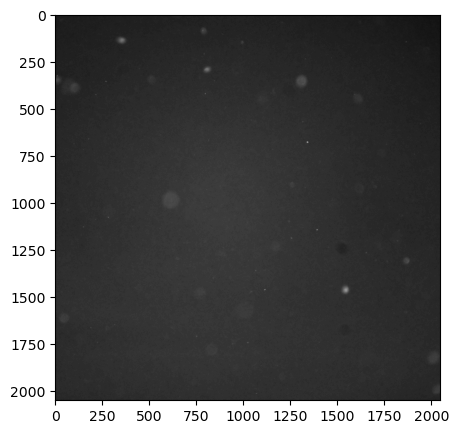

In [109]:
plt.imshow(sub_frames[10]);

### Some image analysis magic

In [110]:
# pre-processing pipeline. Tested out abunch of thresholding techniques and otsu gives the best result: one big
# circle and minimal other stuff
@pims.pipeline
def preprocess_big_droplet(img):
    """
    Apply image processing functions to return a binary image
    """
    # Crop the pictures as for raw images.
    # Apply thresholds
    adaptive_thresh = filters.threshold_triangle(img)
    idx = img > adaptive_thresh
    idx2 = img < adaptive_thresh
    img[idx] = 0
    img[idx2] = 720
    img = ndimage.binary_dilation(img)
    img = ndimage.binary_dilation(img)
    return util.img_as_int(img)


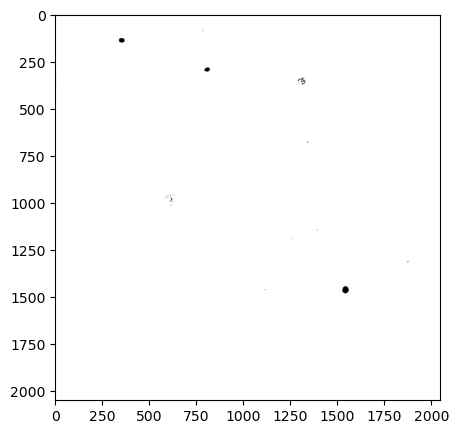

In [111]:
#Let's see what it looks like
frames = preprocess_big_droplet(sub_frames)
plt.imshow(frames[10]);

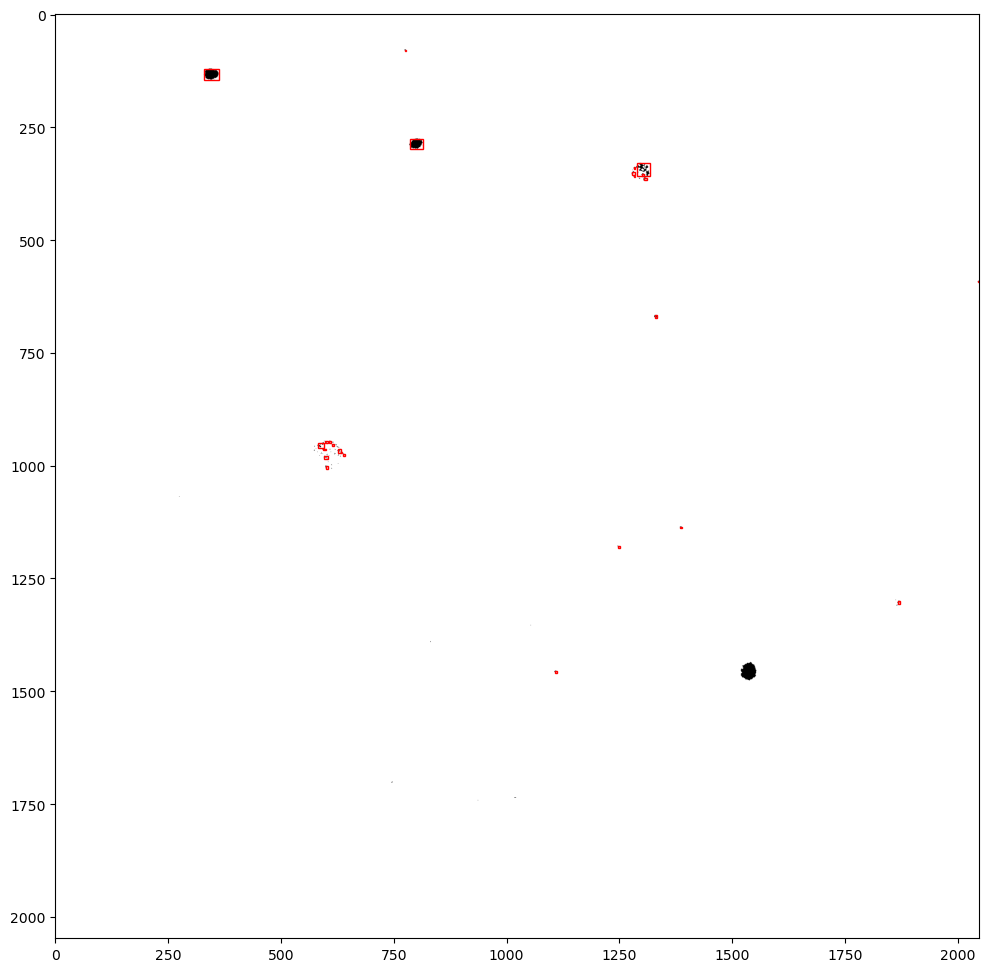

In [113]:
# some tresholding on size and mean intensity. Needed to use a huge region to not include the scale bar

img_example = frames[0]

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small areas
    if region.area < 5 or region.area > 800:
        continue
    # Only black areas
    if region.mean_intensity > 1:
        continue

    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

In [114]:
# Store the big droplet as a feature
warnings.filterwarnings('ignore')

features = pd.DataFrame()
for num, img in enumerate(tqdm.tqdm(frames)):
    white = 255
    label_image = skimage.measure.label(img, background=white)
    for region in skimage.measure.regionprops(label_image, intensity_image=img):
        # Everywhere, skip small and large areas
        if region.area < 5 or region.area > 800:
            continue
    # Only black areas
        if region.mean_intensity > 1:
            continue
        # Store features which survived to the criterions
        features = features.append([{'y': region.centroid[0],
                                     'x': region.centroid[1],
                                     'frame': num,
                                     },])

100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.81it/s]


### Now we track!

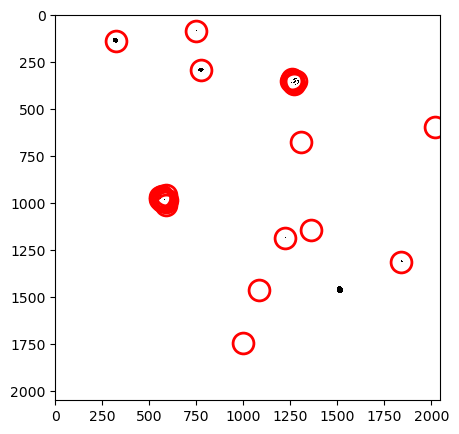

In [115]:
# annotate the center of our droplet
idx = 25
tp.annotate(features[features.frame==(idx)], frames[idx]);


Frame 49: 15 trajectories present.


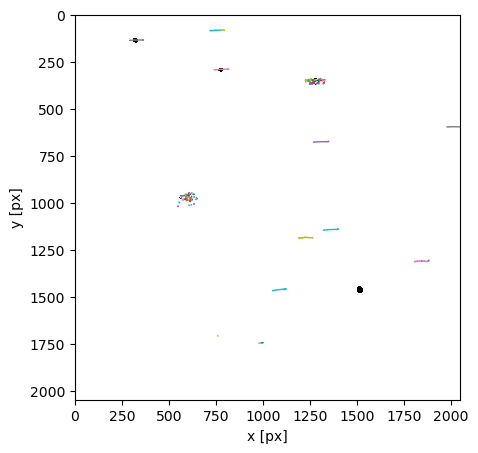

<AxesSubplot: xlabel='x [px]', ylabel='y [px]'>

In [116]:
#plot traj on a frame
search_range = 5
t = tp.link_df(features, search_range, memory=5)
tp.plot_traj(t, colorby='particle',superimpose=frames[25])

### Calculate velocity

In [131]:
col_names = ['dx', 'dy', 'x', 'y', 'frame', 'particle']
# Creating an empty dataframe to store results
pos_data = pd.DataFrame(np.zeros(shape=(1, 6), dtype=np.int64), columns=col_names)
    
for item in set(t.particle):      
        sub = t[t.particle==item]
        
        if sub.shape[0]<=2:
            # Cases in which particle only has 1 or 2 rows of data
            pass
        else:    
            print('Deriving velocities for particle:', str(item))
            dvx = pd.DataFrame(np.gradient(sub.x), columns=['dx',])
            dvy = pd.DataFrame(np.gradient(sub.y), columns=['dy',])
        
            new_df = pd.concat((dvx, dvy, sub.x.reset_index(drop=True), sub.y.reset_index(drop=True),
                                sub.frame.reset_index(drop=True), sub.particle.reset_index(drop=True)),
                                axis=1, names=col_names, sort=False)
            pos_data = pd.concat((pos_data, new_df), axis=0)
    
# This is to get rid of the first 'np.zeros' row and to reset indexes
pos_data = pos_data.reset_index(drop=True)
pos_data = pos_data.drop(0)
pos_data = pos_data.reset_index(drop=True)

Deriving velocities for particle: 13
Deriving velocities for particle: 17
Deriving velocities for particle: 24
Deriving velocities for particle: 25
Deriving velocities for particle: 26
Deriving velocities for particle: 27
Deriving velocities for particle: 28
Deriving velocities for particle: 29
Deriving velocities for particle: 30
Deriving velocities for particle: 37
Deriving velocities for particle: 45
Deriving velocities for particle: 46
Deriving velocities for particle: 47
Deriving velocities for particle: 48
Deriving velocities for particle: 49
Deriving velocities for particle: 50
Deriving velocities for particle: 51
Deriving velocities for particle: 52
Deriving velocities for particle: 53
Deriving velocities for particle: 54
Deriving velocities for particle: 55
Deriving velocities for particle: 56
Deriving velocities for particle: 57
Deriving velocities for particle: 58
Deriving velocities for particle: 59
Deriving velocities for particle: 61
Deriving velocities for particle: 66
D

### plot traj and velocity

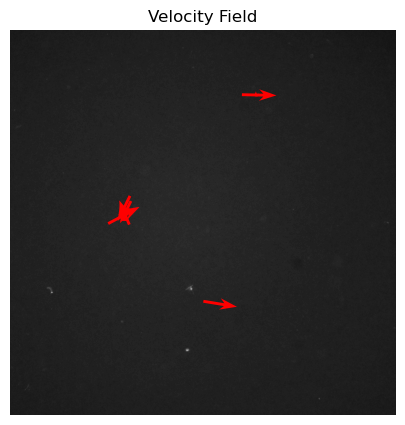

In [119]:
i = 1
d = pos_data[pos_data.frame==i]
plt.imshow(cy5_frames[i])
plt.quiver(d.x, d.y, d.dx, -d.dy, pivot='middle', headwidth=4, headlength=6, color='red')
plt.axis('off')
plt.title("Velocity Field")

plt.savefig('/Users/scliu/Documents/AM_imaging/figs/overnightvelocity_field', dpi=300, bbox_inches='tight')


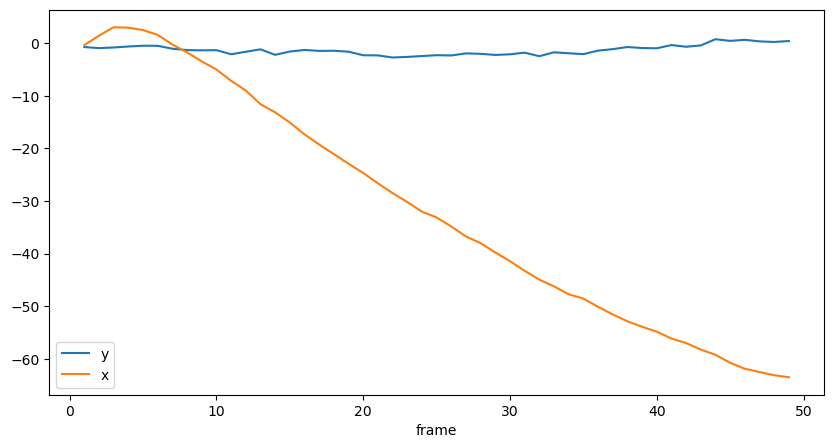

In [127]:
d = tp.compute_drift(t)
d.plot()
plt.show()

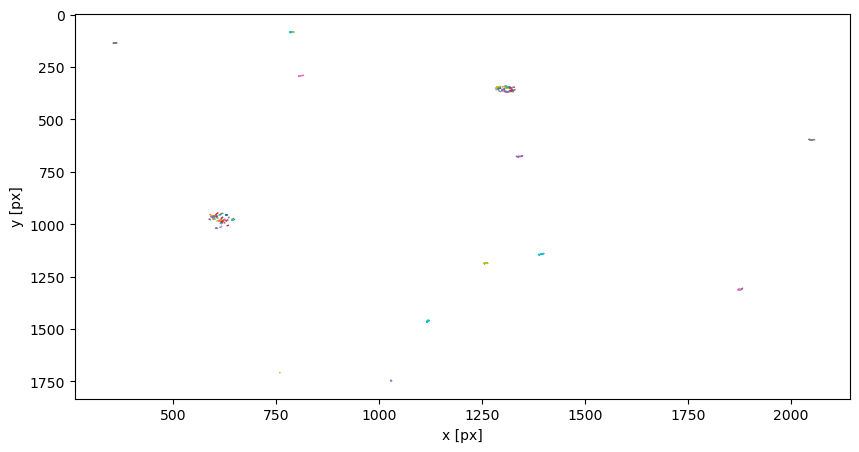

In [128]:
tm = tp.subtract_drift(t.copy(), d)
ax = tp.plot_traj(tm)
plt.show()

In [129]:
#plot velocity

p = figure(width=800, height=400)

p.circle(pos_data['frame']*10, -pos_data['dy']*0.4300668/10, size=10, color="navy", alpha=0.5)

p.title.text = "Droplet vertical velocity"
p.title.align = "left"
p.title.text_font_size = "25px"
p.xaxis.axis_label = "Time elapsed (sec)"
p.yaxis.axis_label = 'Velocity (μm/s)'

show(p)

### Mean Square Displacement

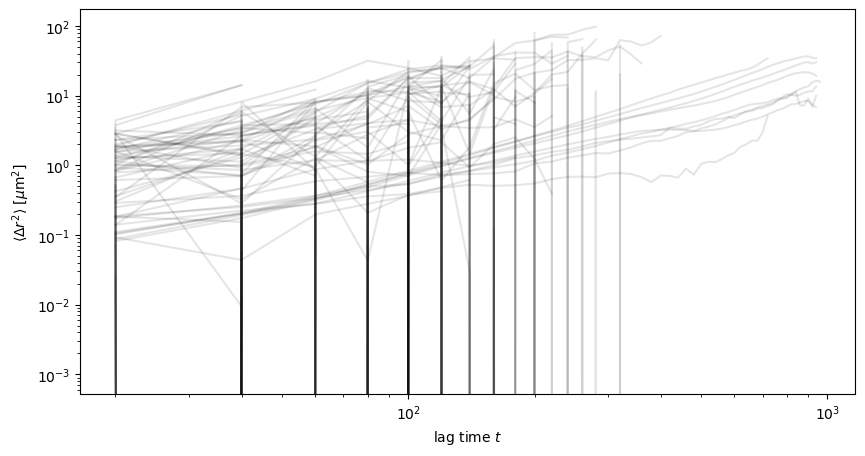

In [134]:
# Calculate and plot MSD vs t

im = tp.imsd(tm, 0.4300668, 0.05)  # microns per pixel = 0.4300668., frames per second = 0.1
fig, ax = plt.subplots()

ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')


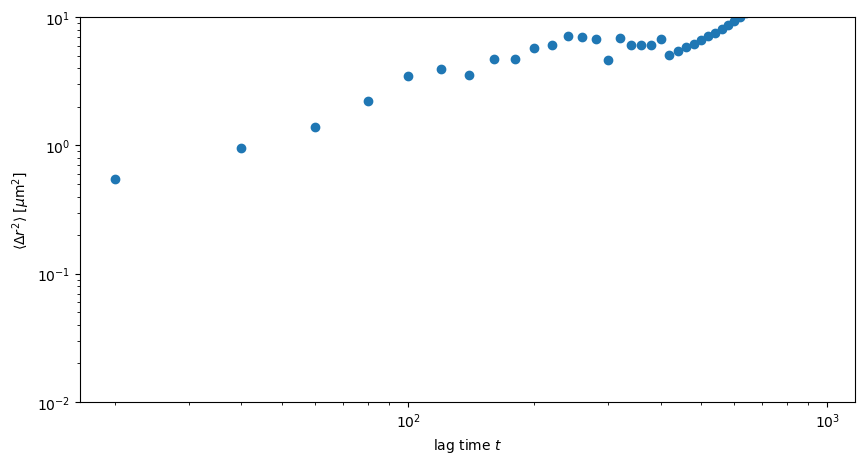

In [136]:
em = tp.emsd(tm, 0.4300668, 0.05)  # microns per pixel = 0.4300668., frames per second = 0.1
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10));

In [124]:
# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)

# Fit the dummy power-law data
pars, cov = curve_fit(f=power_law, xdata=im.index, ydata=im, p0=[0, 0], bounds=(-np.inf, np.inf))
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))
# Calculate the residuals
res = im - power_law(im.index, *pars)

fig, ax = plt.subplots()
ax.plot(im.index, im, 'o')
ax.plot(im.index, power_law(im.index, *pars), linestyle='--', linewidth=1, color='red')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$');
fig.savefig('../figures/tracking/msd_droplet', dpi=400, bbox_inches='tight')
print('n = ', pars[0], '\nA = ', pars[1])

ValueError: array must not contain infs or NaNs